# Sales Analysis


Нам даны данные о продажах онлайн магазина электроники в США за 2019 год. Проанализируем эти данные и ответим на вопросы интересующие бизнес.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
from itertools import combinations
from collections import Counter
import datetime
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

Данные представлены за каждый месяц в отдельном csv файле, объеденим их в один датафрейм

In [2]:
files = [file for file in os.listdir('./Sales Analysis/')] 

all_data = pd.DataFrame()

for file in files:
    df = pd.read_csv('./Sales Analysis/' + file)
    all_data = pd.concat([all_data, df])

all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [3]:
# переименуем столбцы для удобства
all_data = all_data.rename(columns = {'Order ID':'order_id',
                                      'Product' : 'product',
                                      'Quantity Ordered': 'quantity',
                                      'Price Each':'price',
                                      'Order Date':'order_date',
                                      'Purchase Address' : 'address'})
all_data.head()

,order_id,product,quantity,price,order_date,address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


##### EDA и очистка данных

In [4]:
all_data.shape #всего 196573 записей в датафрейме

(196573, 6)

In [5]:
all_data.isnull().sum() 

order_id      571
product       571
quantity      571
price         571
order_date    571
address       571
dtype: int64

In [6]:
# в данных есть пропущенные значения, удалим строки с пустыми значениями
all_data = all_data.dropna(how = 'all')
all_data.head()


,order_id,product,quantity,price,order_date,address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [7]:
all_data.duplicated().sum() #в датафрейме 10315 дублирующихся строк, удалим их
all_data = all_data.drop_duplicates()
all_data.shape

(185687, 6)

In [8]:
all_data.dtypes

order_id      object
product       object
quantity      object
price         object
order_date    object
address       object
dtype: object

In [9]:
# В датафрейме есть данные о времени заказа, которые записаны в формате текста и более того они дублируются. Избевимся от этих строк  
all_data.query('order_date == "Order Date"').head()


,order_id,product,quantity,price,order_date,address
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [10]:
all_data = all_data.query('order_date != "Order Date"')

In [11]:
# приведем данные внутри датафрейма к нужному типу

all_data.order_date = pd.to_datetime(all_data.order_date)
all_data.quantity = pd.to_numeric(all_data.quantity)
all_data.price = pd.to_numeric(all_data.price)

# создадим колонку отдельно с месяцами
all_data['month_num'] = all_data.order_date.dt.month
all_data['month'] = all_data.order_date.dt.month.apply(lambda x: calendar.month_name[x])

In [12]:
# создадим колонку с выручкой от продаж = кол-во проданного * цену

all_data['sales'] = all_data.price * all_data.quantity
all_data.head()

,order_id,product,quantity,price,order_date,address,month_num,month,sales
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,April,23.90
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,April,99.99
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,600.00
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,11.99
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,April,11.99


##### Какой наилучший месяц для продаж? Сколько выручки было получено за этот месяц?

In [13]:
monthly_sales = all_data \
    .groupby(['month', 'month_num'], as_index = False) \
    .agg({'sales':'sum'}) \
    .sort_values('month_num', ascending = True)
monthly_sales

,month,month_num,sales
4,January,1,1821413.16
3,February,2,2200078.08
7,March,3,2804973.35
0,April,4,3389217.98
8,May,5,3150616.23
6,June,6,2576280.15
5,July,7,2646461.32
1,August,8,2241083.37
11,September,9,2094465.69
10,October,10,3734777.86


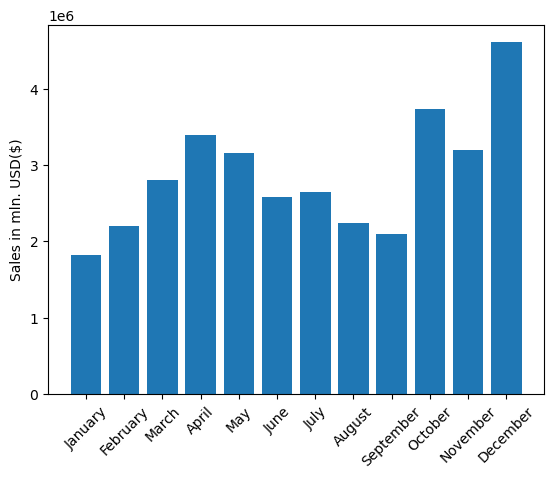

In [14]:
plt.bar(monthly_sales.month, monthly_sales.sales)
plt.ylabel('Sales in mln. USD($)')
plt.xticks(rotation=45)
plt.show()

Наибольшая выручка была в декабре, вероятнее всего это связано с новогодними празниками, так как люди в предверии праздников часто покупают в подарок электронику. Вторые по величине выручки у нас Апрель и Октябрь, такой скачок в продажах возможна из-за маркетинга магазина, возможно в эти месяцы магазин больше рекламировался.

##### В каком городе у магазина наибольшие продажи?

In [15]:
# отделим название города из колонки с адресом магазина, при это оставим название штатов, так как в разных штатах могут быть города с одинаковым названием

def get_city(address):
    '''функция get_city берет на вход один арумент:
    строку c адресом доставки и возвращает название 
    города из адреса'''
    
    return address.split(',')[1]

def get_state(address):
    '''функция get_state берет на вход один арумент:
    строку c адресом доставки и возвращает название 
    штата из адреса'''
    
    return address.split(',')[2].split(' ')[1]


all_data['city'] = all_data.address.apply(lambda x: f'{get_city(x)} ({get_state(x)})')
all_data.head()

,order_id,product,quantity,price,order_date,address,month_num,month,sales,city
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,April,23.90,Dallas (TX)
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,April,99.99,Boston (MA)
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,600.00,Los Angeles (CA)
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,11.99,Los Angeles (CA)
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,April,11.99,Los Angeles (CA)


In [16]:
city_sales = all_data \
    .groupby('city', as_index = False) \
    .agg({'sales':'sum'}) 
city_sales 

,city,sales
0,Atlanta (GA),2794199.07
1,Austin (TX),1818044.33
2,Boston (MA),3658627.65
3,Dallas (TX),2765373.96
4,Los Angeles (CA),5448304.28
5,New York City (NY),4661867.14
6,Portland (ME),449321.38
7,Portland (OR),1870010.56
8,San Francisco (CA),8254743.55
9,Seattle (WA),2745046.02


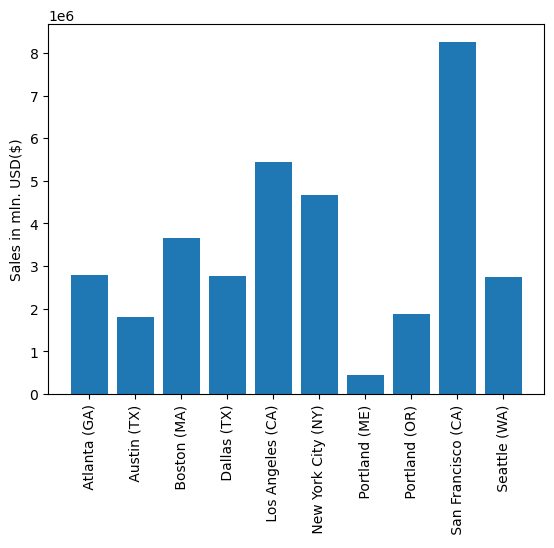

In [17]:
plt.bar(city_sales.city, city_sales.sales)
plt.ylabel('Sales in mln. USD($)')
plt.xticks(rotation=90)
plt.show()

Наибольшую выручку от продаж магазин получил в Сан_Франциско. Посмотрим также, на количество проданных товаров в разрезе городов.


In [18]:
city_sales_quan = all_data \
    .groupby('city', as_index = False) \
    .agg({'quantity':'sum'}) 
city_sales_quan

,city,quantity
0,Atlanta (GA),16584
1,Austin (TX),11137
2,Boston (MA),22494
3,Dallas (TX),16707
4,Los Angeles (CA),33247
5,New York City (NY),27903
6,Portland (ME),2746
7,Portland (OR),11291
8,San Francisco (CA),50169
9,Seattle (WA),16534


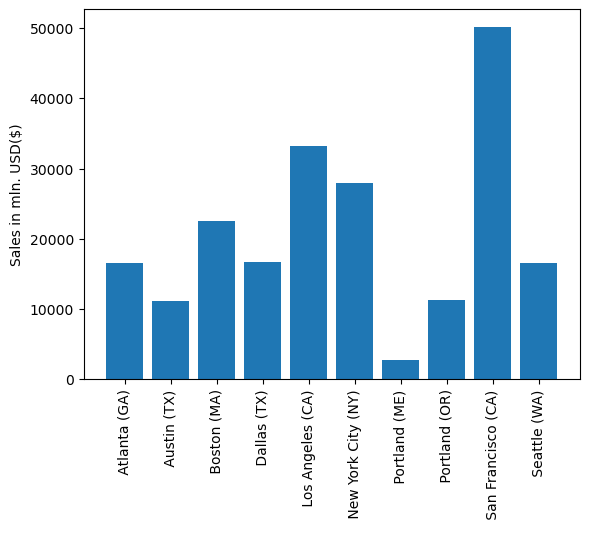

In [19]:
plt.bar(city_sales_quan.city, city_sales_quan.quantity)
plt.ylabel('Sales in mln. USD($)')
plt.xticks(rotation=90)
plt.show()

Действительно и по количеству проданных товаров и по выручке Сан-Франциско значительно превосходит другие города. Возможна данная тенденция связана с тем что в Силиконовой долине бОльшая потребность в электронике чем в других городах, так как город специализируется по большей части на ИТ - отрасли. Еще одной возможной причиной может быть то,что в Сан-Франциско доля обеспечанных людей больше чем в других городах.
Также видно, что Потрланд очень сильно уступает по продажам, возможно стоит обратить внимание на маркетинговую стратегию в данном городе. 

##### В какое время мы должны показывать рекламу, чтобы увеличить вероятность того, что клиент купит продукт ?

In [20]:
all_data['hour'] = all_data.order_date.dt.hour #извлечем часы из даты заказа


In [21]:
# Посчитаем кол-во заказов на каждый час
orders_by_hour = all_data \
    .groupby('hour', as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id' : 'number_of_orders'})
orders_by_hour

,hour,number_of_orders
0,0,3902
1,1,2347
2,2,1242
3,3,830
4,4,852
5,5,1320
6,6,2481
7,7,4002
8,8,6252
9,9,8740


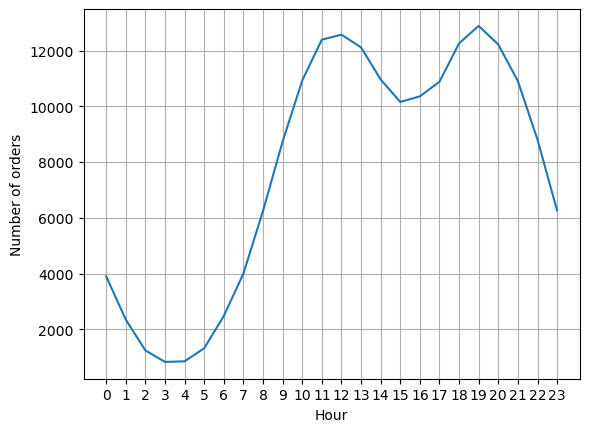

In [22]:
sns.lineplot(orders_by_hour.number_of_orders)
plt.ylabel('Number of orders')
plt.xlabel('Hour')
plt.xticks(orders_by_hour.hour)
plt.grid()
plt.show()

На графике видно, что пик захода клиентов в магазин и оформления заказов приходится на промежутки 11:00-12:00 часов и 18:00-19:00 часов. Я бы рекомендовала запускать рекламу к 11 и 19 часам.

#####  Какие пары товаров чаще всего вместе продаются?

In [23]:
#  посмотрим на записи с одинаковым order_id

all_data[all_data.order_id.duplicated(keep = False)].head(10) 

,order_id,product,quantity,price,order_date,address,month_num,month,sales,city,hour
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,600.00,Los Angeles (CA),14
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,April,11.99,Los Angeles (CA),14
18,176574,Google Phone,1,600.00,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",4,April,600.00,Los Angeles (CA),19
19,176574,USB-C Charging Cable,1,11.95,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",4,April,11.95,Los Angeles (CA),19
32,176586,AAA Batteries (4-pack),2,2.99,2019-04-10 17:00:00,"365 Center St, San Francisco, CA 94016",4,April,5.98,San Francisco (CA),17
33,176586,Google Phone,1,600.00,2019-04-10 17:00:00,"365 Center St, San Francisco, CA 94016",4,April,600.00,San Francisco (CA),17
119,176672,Lightning Charging Cable,1,14.95,2019-04-12 11:07:00,"778 Maple St, New York City, NY 10001",4,April,14.95,New York City (NY),11
120,176672,USB-C Charging Cable,1,11.95,2019-04-12 11:07:00,"778 Maple St, New York City, NY 10001",4,April,11.95,New York City (NY),11
129,176681,Apple Airpods Headphones,1,150.00,2019-04-20 10:39:00,"331 Cherry St, Seattle, WA 98101",4,April,150.00,Seattle (WA),10
130,176681,ThinkPad Laptop,1,999.99,2019-04-20 10:39:00,"331 Cherry St, Seattle, WA 98101",4,April,999.99,Seattle (WA),10


Как можно увидеть из данных, есть заказы, которые были оформлены в одно и тоже время и на одинаковый адрес и имеют один и тот же id, то есть по схеме данных видно, что каждый заказ даже одного и того же покупателя записывается с новой строки

In [24]:
# создадим новую колонку в датафрейме с объединенными товарами с одинаковым id
all_data['grouped'] = all_data\
    .groupby('order_id')['product']\
    .transform(lambda x: ','.join(x))

# удалим дублирующиеся комбинации товаров в заказах
df = all_data[['order_id', 'grouped']].drop_duplicates()

In [25]:
df.head()

,order_id,grouped
0,176558,USB-C Charging Cable
2,176559,Bose SoundSport Headphones
3,176560,"Google Phone,Wired Headphones"
5,176561,Wired Headphones
6,176562,USB-C Charging Cable


In [26]:
#посчитаем самые популярные пару товаров в заказах
count = Counter()

for row in df['grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list,2)))
    
#выведем пары товаров и количество вхождений в заказх для них  
for key, value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1002
('Google Phone', 'USB-C Charging Cable') 985
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 413
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 159
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


По результату видно, что наиболее популярные пары товаров это всегда телефоны и к телефону подходящее зарядное устройство или наушники. 

##### Какой самый попурный товар в магазине?

In [27]:
pop_prod = all_data\
    .groupby('product', as_index = False)\
    .agg({'quantity':'sum'})



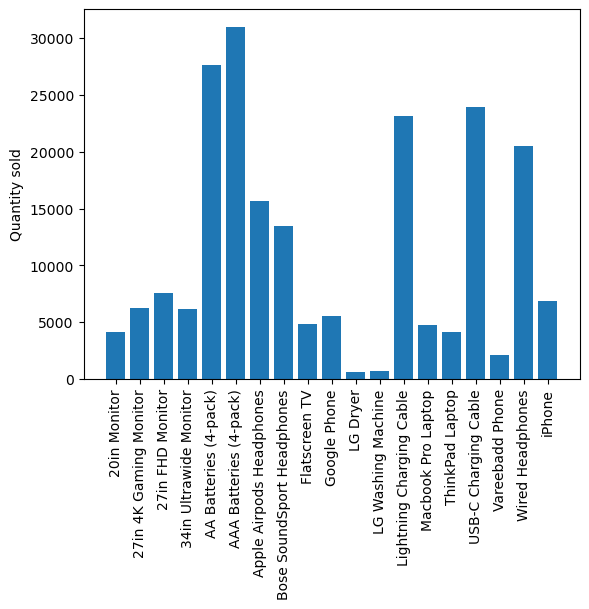

In [28]:
plt.bar(pop_prod['product'], pop_prod['quantity'])
plt.ylabel('Quantity sold')
plt.xticks(rotation=90)
plt.show()

Наиболее популярные товары в магазине это батарейки и зарядные устройства. Наиболее очевидная причина этого, то что эти тоары дешевле, например чем LG Dryer. 

Наложим цены на график, чтобы посмотреть есть ли какая-то корреляция между количеством проданного и ценой товара.

In [29]:
pop_prod = all_data\
    .groupby('product', as_index = False)\
    .agg({'quantity':'sum', 'price':'mean'})
pop_prod.head()

,product,quantity,price
0,20in Monitor,4126,109.99
1,27in 4K Gaming Monitor,6239,389.99
2,27in FHD Monitor,7541,149.99
3,34in Ultrawide Monitor,6192,379.99
4,AA Batteries (4-pack),27615,3.84


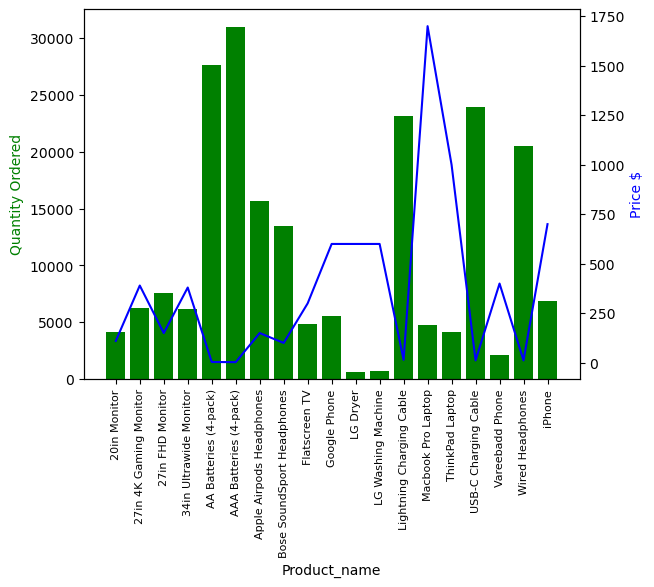

In [30]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(pop_prod['product'], pop_prod['quantity'], color = 'g')
ax2.plot(pop_prod['product'], pop_prod['price'], 'b-')

ax1.set_xlabel('Product_name')
ax1.set_ylabel('Quantity Ordered', color = 'g')
ax2.set_ylabel('Price $', color = 'b')

ax1.set_xticklabels(pop_prod['product'], rotation = 'vertical', size = 8)

plt.show()

По графику видно, что гипотеза о том,что дорогие продукты продаются реже потверждается, у батареек и зарядных устройств цена ниже всего --> они чаще всего покупаются. Однако по графику видно, что например Macbook Pro имеет экстремально выскоую цену по сравнению с другими товарами магазина, одна продается чаще чем например LG Dryer или Whasing Machine. Я предполагаю, что это объясняется тем, что на ноутбуки выше спрос в США чем на бытовую технику, так как много студентов, работников покупают макбуки для работы/учебы.